In [2]:
from gym_car_intersect.envs.hack_env_discrete import CarRacingHackaton
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import tensorflow as tf
from tensorflow.contrib.distributions.python.ops import relaxed_onehot_categorical

В ноутбуке реализован Soft Actor Acritic для дискретного пространства действий.

В самом низу тетрадки небольшое описание проделанного.

Ниже несколько классов-оберток для удобства обучения.

In [3]:
# base class for all SAC parts 
class SAC__Base:
    
    def copy_weights_from_model(self, other_model, transform_func=None):
        '''
        Copy to current model weights from other_model.
        
        transform_func allow you to assing to the model transformed weights. 
        It should be (new_weight, old_weight) -> weight_to_assing 
        '''
        if transform_func is None:
            transform_func = lambda w_new, w_old: w_new
        update_weights = [
            tf.assign(old, transform_func(new, old))
            for (old, new) 
            in zip(
                tf.trainable_variables(self.scope_name),
                tf.trainable_variables(other_model.scope_name)
            )
        ]
        self.session.run(update_weights)
            
    def get_variables(self):
        return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.scope_name)
    
    
    def load_from_file(self, path, file_name):
        saver = tf.train.import_meta_graph(file_name + '.meta')
        saver.restore(
            self.session,
            tf.train.latest_checkpoint(path),
        )
    
    def save_to_file(self, file_name):
        saver = tf.train.Saver(self.get_variables())
        saver.save(self.session, file_name)

In [6]:
class SAC__ValueNet(SAC__Base):
    '''
    Implementaion of V function
    '''
    
    def __init__(self, session, state_size, action_size, hidden_size=128, name='_v1'):
        self.session = session
        self.scope_name = 'SAC__ValueNet' + name
        
        with tf.variable_scope(self.scope_name):
            # V-value architecture from just two FC layer with relu activation
            self.state = tf.placeholder(
                dtype=tf.float32, 
                shape=[None, state_size], 
                name='ValueNet_state'
            )
            # (None, state_size) -> (None, hidden_size)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(self.state)
            # (hidden_size, state_size) -> (None, hidden_size)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            # (hidden_size, state_size) -> (None, 1)
            self.value = tf.layers.Dense(units=1, activation=None)(x)
            
            # place holder for `Q(s, a) - log(pi(a|s))`
            self.target = tf.placeholder(
                dtype=tf.float32,
                shape=[None, 1],
                name='ValueNet_target'
            )
            # use stop gradient to prevent the gradient spreading to target, that is `Q(s, a) - log(pi(a|s))`
            loss = tf.reduce_mean( (self.value - tf.stop_gradient(self.target))**2 )
            self.optimizer = tf.train.AdamOptimizer(0.003)
            
            # minimizing step over trainable params in this scope
            self.train_step = self.optimizer.minimize(
                loss,
                var_list=self.get_variables(),
            )
            
    def get_value(self, state):
        return self.session.run(
            self.value,
            feed_dict={
                self.state: state,
            },
        )

    def make_update_step(self, state, target):
        self.session.run(
            self.train_step,
            feed_dict={
                self.state: state,
                self.target: target,
            }
        )

In [7]:
class SAC__QNet(SAC__Base):
    '''
    Implementation of Q function.
    '''
    
    def __init__(self, session, state_size, action_size, hidden_size=128, name='_v1'):
        self.session = session
        self.scope_name = 'SAC__QNet' + name
        
        with tf.variable_scope(self.scope_name):
            # net architecture
            self.state = tf.placeholder(
                dtype=tf.float32,
                shape=[None, state_size],
                name='QNet_state'
            )
            self.action = tf.placeholder(
                dtype=tf.float32,
                shape=[None, action_size],
                name='QNet_action'
            )
            
            x_state = tf.layers.Dense(units=hidden_size, activation='relu')(self.state)
            x_action = tf.layers.Dense(units=hidden_size, activation='relu')(self.action)
            
            x = tf.concat([x_state, x_action], axis=1)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            # final shape [None, 1]
            self.qvalue = tf.layers.Dense(units=1)(x)
            
            self.optimizer = tf.train.AdamOptimizer(0.003)
            
            # here one should set target as `r(s_t, a_t) + gamma * V(s_{t+1})`
            self.target = tf.placeholder(
                dtype=tf.float32,
                shape=[None, 1],
                name='QNet_target'
            )
            loss = tf.reduce_mean( (self.qvalue - tf.stop_gradient(self.target))**2 )
            self.train_step = self.optimizer.minimize(
                loss,
                var_list=self.get_variables(),
            )

    def get_q(self, state, action):
        return self.session.run(
            self.qvalue,
            feed_dict={
                self.state: state,
                self.action: action,
            },
        )

    def make_update_step(self, state, action, target):
        self.session.run(
            self.train_step,
            feed_dict={
                self.state: state,
                self.action: action,
                self.target: target,
            },
        )

In [10]:
class SAC__Policy(SAC__Base):
    '''
    Implementation of Policy function.
    '''
    def __init__(self, session, state_size, action_size, hidden_size=128, name='_v1'):
        self.session = session
        self.scope_name = 'SAC__Policy' + name
        
        with tf.variable_scope(self.scope_name):
            # net architecture
            self.state = tf.placeholder(
                dtype=tf.float32,
                shape=[None, state_size],
                name='Policy_state'
            )
            self.action = tf.placeholder(
                dtype=tf.float32,
                shape=[None, action_size],
                name='Policy_action'
            )
            
            x = tf.layers.Dense(units=hidden_size, activation='relu')(self.state)
            x = tf.layers.Dense(units=hidden_size, activation='relu')(x)
            # final shape [None, 1]
            x = tf.layers.Dense(units=action_size)(x)
            self.policy_probs = tf.math.softmax(x, axis=1)
            
            # temperature to control Gumbel-Softmax
            self.temperature = tf.placeholder(
                dtype=tf.float32,
                name='Policy_temperature'
            )
            self.dist = relaxed_onehot_categorical.RelaxedOneHotCategorical(
                temperature=self.temperature,
                probs=self.policy_probs
            )
            # shape [None, action_size]
            self.generated_actions_probs = self.dist.sample()
            # shape [None, 1]
            self.generated_action = tf.one_hot(
                tf.math.argmax(self.generated_actions_probs, axis=1),
                action_size,
            )
            
            self.optimizer = tf.train.AdamOptimizer(0.003)
            
            # target should be Q(state, all_actions),
            #     to match bu shape generated_actions_probs: [None, action_size]
            self.target = tf.placeholder(
                dtype=tf.float32,
                shape=[None, 1],
                name='Policy_target'
            )
            loss = tf.reduce_mean( tf.log(self.generated_actions_probs) - tf.stop_gradient(self.target) )
            self.train_step = self.optimizer.minimize(
                loss,
                var_list=self.get_variables(),
            )  
        
    def make_update_step(self, state, target, temperature=0.5):
        self.session.run(
            self.train_step,
            feed_dict={
                self.state: state,
                self.target: target,
                self.temperature: temperature,
            }
        )
        
    def get_policy_probs(self, state, temperature=0.5):
        return self.session.run(
            self.generated_actions_probs,
            feed_dict={
                self.state: state,
                self.temperature: temperature,
            }
        )    
    
    def get_policy_action(self, state, temperature=0.5):
        return self.session.run(
            self.generated_action,
            feed_dict={
                self.state: state,
                self.temperature: temperature,
            }
        )
    
    def get_policy_actions_with_probs(self, state, temperature=0.5):
        return self.session.run([
                self.generated_action,
                self.generated_actions_probs,
            ],
            feed_dict={
                self.state: state,
                self.temperature: temperature,
            }
        )

In [12]:
class SAC__Agent:
    '''
    Class of agent, whitch controll update steps of all sub-net and can be used in expluatation.
    '''
    def __init__(self, 
                 session, 
                 state_size, 
                 action_size, 
                 hidden_size=128, 
                 name='agent_1', 
                 info=''):
        # save meta info
        self.name = name
        self.info = info
        
        # save env hyper params
        self.action_size = action_size
        self.state_size = state_size
        
        # here init agent nets
        self._Q1 = SAC__QNet(session, state_size, action_size, hidden_size, '_q1')
        self._Q2 = SAC__QNet(session, state_size, action_size, hidden_size, '_q2')
        self._V = SAC__ValueNet(session, state_size, action_size, hidden_size, '_v1')
        self._V_ExpSmooth = SAC__ValueNet(session, state_size, action_size, hidden_size, '_VSmooth')
        self._Policy = SAC__Policy(session, state_size, action_size, hidden_size, '_p1')
        
        # init weights
        session.run(tf.initialize_all_variables())
        
        # make V_exp_smooth net equal to V net
        self._V_ExpSmooth.copy_weights_from_model(self._V)
        
        
    def update_step(
            self, 
            replay_batch, 
            temperature=0.5, 
            gamma=0.7,
            v_exp_smooth_factor=0.8,
            need_update_VSmooth=False,
    ):
        # shape of replay_batch : tuple of (
        #     [batch_size, state_size], - state
        #     [batch_size, actoin_size],- action
        #     [batch_size, 1],          - revard
        #     [batch_size, state_size], - new state
        #     [batch_size, 1]           - is it done? (1 for done, 0 for not yet)
        # )
        state, action, reward, new_state, done_flag = replay_batch
        batch_size = len(state)
        
        # cur_policy_actions is [batch_size, action_szie]
        cur_policy_actions, cur_policy_probs = self._Policy.get_policy_actions_with_probs(
            state=state,
            temperature=temperature,
        )
        # compute log prods for the most probabel action
        #     and reshape it to [batch_size, 1]
        cur_actions_log_probs = np.reshape(
            np.log(np.max(cur_policy_probs, axis=1)),
            (batch_size, 1),
        )
        
        # shape: [batch_size, 1], get min of Q function in accordance with ariginal article
        q_func_current = np.min(
            np.array([
                self._Q1.get_q(state, cur_policy_actions),
                self._Q2.get_q(state, cur_policy_actions),
            ]),
            axis=0
        )
        
        # update Value function
        self._V.make_update_step(
            state=state,
            target=q_func_current - cur_actions_log_probs
        )
        
        #  update both Q functions
        q_func_target = reward + gamma * (1 - done_flag) * self._V_ExpSmooth.get_value(new_state)
        self._Q1.make_update_step(
            state=state,
            action=action,
            target=q_func_target,
        )
        self._Q2.make_update_step(
            state=state,
            action=action,
            target=q_func_target,
        )
        
        # update Policy function
        self._Policy.make_update_step(
            state=state,
            target=q_func_current,
        )
        
        # we donn't need update V_exp_smmoth on each step
        if need_update_VSmooth:
            self.update_V_ExpSmooth(v_exp_smooth_factor)
        
        
    def update_V_ExpSmooth(self, v_exp_smooth_factor):
        # update V_exp_smooth
        self._V_ExpSmooth.copy_weights_from_model(
            self._V,
            transform_func=
            lambda w_new, w_old: w_new * v_exp_smooth_factor + (1 - v_exp_smooth_factor) * w_old,
        )
        
    def save(self, folder):
        import os
        if not os.path.exists(folder):
            os.makedirs(folder)
        for model in [self._Q1, self._Q2, self._V, self._V_ExpSmooth, self._Policy]:
            model.save_to_file(os.path.join(folder, model.get_name()))
        
    def get_batch_actions(self, state, need_argmax=False, temperature=0.5):
        # state: [batch_size, state_size]
        actions = self._Policy.get_policy_action(
            state=state,
            temperature=temperature,
        )
        if need_argmax:
            return np.argmax(actions, axis=1)
        return actions
    
    def get_single_action(self, state, need_argmax=False, temperature=0.5):
        # state: [state_size, ]
        # return [action_szie, ]
        action = self._Policy.get_policy_action(
            state=[state],
            temperature=temperature,
        )[0]
        if need_argmax:
            return np.argmax(action)
        return action

In [13]:
# just to try agent

tf.reset_default_graph()

session = tf.Session()


test_Agent = SAC__Agent(session, 3, 2)
session.run(tf.initialize_all_variables())

#batch size = 4
# test_Agent.update_step((
#     np.array([[1, 1, 1], [2, 2, 2], [1, 2, 3], [2, 3, 4]]), # state
#     np.array([[0, 1], [0, 1], [1, 0], [1, 0]]), # action
#     np.array([[1], [2], [3], [-1]]), # reward
#     np.array([[1, 1, 2], [2, 2, 3], [1, 3, 3], [2, 2, 4]]), # new state
# ))


print(test_Agent.get_single_action([1, 2, 3], need_argmax=True, temperature=100))
print(test_Agent.get_batch_actions(
    [[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]],
    need_argmax=True, 
    temperature=0.01
))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The T

будем учить агента, исользуя как состояние его координаты и точку назначания

In [35]:
class Holder:
    '''
    Class to hold agent, environment and replay buffer. 
    Also it is a place to controll hyperparameters of learning process.
    '''
    
    def __init__(self, session, batch_size=32, hidden_size=256, buffer_size=50 * 1000):
        self.session = session
        self.batch_size = batch_size
        
        # for reward history 
        self.update_steps_count = 0
        self.history = []
        
        # init replay buffer
        self.cur_write_index = 0
        self.buffer_size = buffer_size
        self.buffer = [
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 1), dtype=np.float32),
            np.zeros((buffer_size, 5), dtype=np.float32),
            np.zeros((buffer_size, 1), dtype=np.float32),
        ]
        
        # init environment and agent
        self.env = CarRacingHackaton(num_bots=0, start_file=None)
        self.agent = SAC__Agent(session, state_size=5, action_size=5, hidden_size=hidden_size)
        self.goal = None
        
    def reset_env(self):
        self.env.reset()
        goal = np.array(self.env.car_goal_poly)
        self.goal = np.array([np.mean(goal[:, 0]), np.mean(goal[:, 1])])
        
        
    def insert_N_sample_to_replay_memory(self, N, temperature=0.5):
        for _ in range(N):
            
            # resen env, if we hanen't goal
            if self.goal is None:
                self.reset_env()
            
            state = np.hstack([self.env.state[1], self.goal])
            action = self.agent.get_single_action(
                state,
                need_argmax=False,
                temperature=temperature,
            )
            new_state, reward, done, info = self.env.step(np.argmax(action))
            
            # state
            self.buffer[0][self.cur_write_index] = state
            # action
            self.buffer[1][self.cur_write_index] = action
            # reward
            self.buffer[2][self.cur_write_index] = np.array([reward])
            # new state
            self.buffer[3][self.cur_write_index] = np.hstack([np.array(new_state[1]), self.goal])
            # done flag
            self.buffer[4][self.cur_write_index] = 1.0 if done else 0.0
            self.cur_write_index += 1
            if self.cur_write_index >= self.buffer_size:
                self.cur_write_index =  0
            
            # reset env if done
            if done:
                self.reset_env()
                
                
    def iterate_over_buffer(self, steps):
        cur_steps = 0
        is_break = False
        while True:
            indexes = np.arange(len(self.buffer[0]))
            np.random.shuffle(indexes)
            
            for ind in range(0, len(indexes), self.batch_size):
                yield (
                    self.buffer[i][indexes[ind : ind + self.batch_size]]
                    for i in range(5)
                )
                cur_steps += 1
                if cur_steps >= steps:
                    is_break = True
                    break
            if is_break:
                break
    
    def update_agent(
            self, 
            update_step_num=500,
            temperature=0.5,
            gamma=0.7,
            v_exp_smooth_factor=0.8,
            need_update_VSmooth=False
    ):
        for batch in self.iterate_over_buffer(update_step_num):
            self.update_steps_count += 1
            self.agent.update_step(
                batch, 
                temperature=temperature, 
                gamma=gamma,
                v_exp_smooth_factor=v_exp_smooth_factor,
                need_update_VSmooth=need_update_VSmooth,
            )
            
    def get_test_game_total_reward(
            self, 
            max_steps=1000, 
            temperature=10,
            add_to_memory=True,
            yield_visualization=False,
    ):
        self.reset_env()
        total_revard = 0
        was_game_finit = False
        
        for _ in range(max_steps):
            # make action
            state = np.hstack([self.env.state[1], self.goal])
            action = self.agent.get_single_action(
                state,
                need_argmax=False,
                temperature=temperature,
            )
            new_state, reward, done, info = self.env.step(np.argmax(action))
            
            total_revard += reward
            
#             if yield_visualization:
#                 yield self.env.state[0], action, reward, done    
            
            if done:
                was_game_finit = True
                break
        
        self.reset_env()
        if not was_game_finit:
            total_revard = -9999
            
        if add_to_memory:
            self.history.append([self.update_steps_count, total_revard])
        
        return total_revard
    
    
    def get_test_game_mean_reward(
        self,
        n_games=10,
        max_steps=1000, 
        temperature=10,
        add_to_memory=True
    ):
        sm = 0
        for _ in range(n_games):
            sm += self.get_test_game_total_reward(max_steps, temperature, add_to_memory=False)
        sm /= n_games
        
        if add_to_memory:            
            self.history.append([self.update_steps_count, sm])
            
        return sm
    
    def get_history(self):
        return np.array(self.history)

Инициализируем финальный граф

In [36]:
tf.reset_default_graph()

session = tf.Session()

holder = Holder(session)

In [37]:
%time

# fill replay buffer with random exploratoin actions


holder.insert_N_sample_to_replay_memory(10000, temperature=0.00001)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


потретируем модель

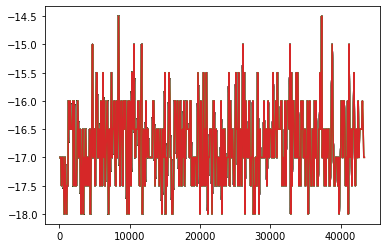

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(10 * 1000):
    gamma = min(0.9, 0.1 + i / 500)
    temperature = min(0.7, 0.2 + i / 1000)
    
    holder.insert_N_sample_to_replay_memory(1000, temperature=temperature - 0.1)
    holder.update_agent(update_step_num=100, temperature=temperature, gamma=gamma)
    holder.agent.update_V_ExpSmooth(0.8)

    holder.get_test_game_mean_reward()
    
    clear_output(wait = True)
    ax.plot(holder.get_history()[:, 0], holder.get_history()[:, 1])
    display(fig)
    
    
    plt.pause(0.5)

чуть более детальный график

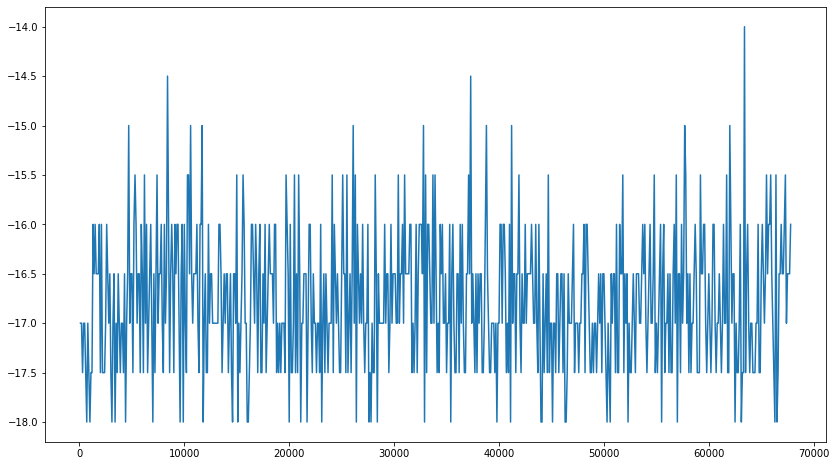

In [39]:
plt.figure(figsize=(14, 8)) 
plt.plot(holder.get_history()[:, 0], holder.get_history()[:, 1])
plt.show()

**Про проделанную работу**

Прочитал статью написал код. Во время написания понял, что сферическое нормальное распределение (как в оригинальной стате) не подойдет для дискретного пространства действий и, поискав, применил Gumbel-Softmax для применения reparametrization trick в дискретном пространстве.

Далее некоторое время настраивал среду и обучал агента. Как видно на графике ревордов промежуточных игр, агент пока не обучился делать хоть что-то разумное. В то же время в оригинальное статье на графиках видно обучение по несколько миллионов игр, а здесь агент сыграл чуть больше 1000.

Нужно бы обучать агента дольше (у меня после неписания кода осталось немного времени) и попробовать сделать больше нейронов в слоях (в оригинальной статье 256 на слой, у меня 16 в силу небольшой вычислительной мощности).